## Summary notes

Use simple exponential smoothing method to model a non-seasonal time series with no trend.

Data was sourced from Rdatasets[^1] using StatsModels `Datasets` package.[^2]

We use StatsModels' `SimpleExpSmoothing`[^3] class to model the time series.

This topic is covered in M249, Book 2, Part 2.6 & 2.9.

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels import api as sm
from statsmodels import datasets
from statsmodels.tsa import api as tsa
from statsmodels.graphics import tsaplots
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

## Main

### Load the data

In [3]:
bomregions = datasets.get_rdataset('bomregions', package='DAAG', cache=True)
bomregions.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       109 non-null    int64  
 1   eastAVt    99 non-null     float64
 2   seAVt      99 non-null     float64
 3   southAVt   99 non-null     float64
 4   swAVt      99 non-null     float64
 5   westAVt    99 non-null     float64
 6   northAVt   99 non-null     float64
 7   mdbAVt     99 non-null     float64
 8   auAVt      99 non-null     float64
 9   eastRain   109 non-null    float64
 10  seRain     109 non-null    float64
 11  southRain  109 non-null    float64
 12  swRain     109 non-null    float64
 13  westRain   109 non-null    float64
 14  northRain  109 non-null    float64
 15  mdbRain    109 non-null    float64
 16  auRain     109 non-null    float64
 17  SOI        109 non-null    float64
 18  co2mlo     50 non-null     float64
 19  co2law     79 non-null     float64
 20  CO2       

### Initialise and plot the time series

The first observation is in 1900.

In [4]:
bomregions.data['Year'].head(1)

0    1900
Name: Year, dtype: int64

In [5]:
ts_srain = pd.Series(
    data=bomregions.data['southRain'].to_numpy(),
    name='obs',
    index=pd.date_range(
        start='1900',
        periods=bomregions.data['southRain'].size,
        freq='A-DEC',
        name='year'
    )
)
ts_srain.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 109 entries, 1900-12-31 to 2008-12-31
Freq: A-DEC
Series name: obs
Non-Null Count  Dtype  
--------------  -----  
109 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


### Plot the time series

Text(5.960000000000001, 0.5, 'south rainfall')

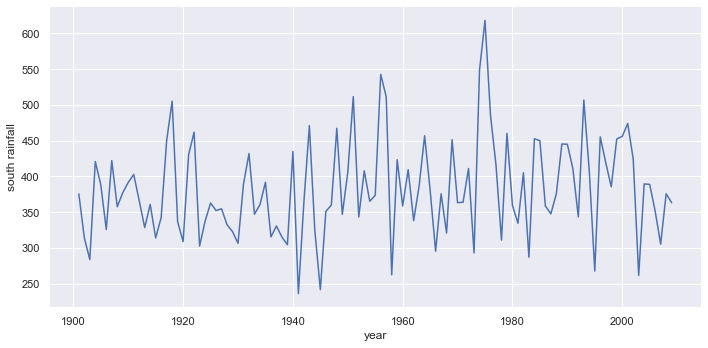

In [6]:
sns.relplot(x=ts_srain.index, y=ts_srain, kind='line', aspect=2)
plt.ylabel('south rainfall')

### Smooth the time series

Model and fit the time series.

In [7]:
smoothed = tsa.SimpleExpSmoothing(ts_srain, initialization_method='estimated')
fitted = smoothed.fit()

Construct a `DataFrame` holding both the *observed* and *fitted* time series.

In [8]:
time_series = pd.merge(
    left=ts_srain,
    right=fitted.fittedvalues.rename('fit'),
    left_index=True,
    right_index=True
)

Plot the observerved and fitted time series.

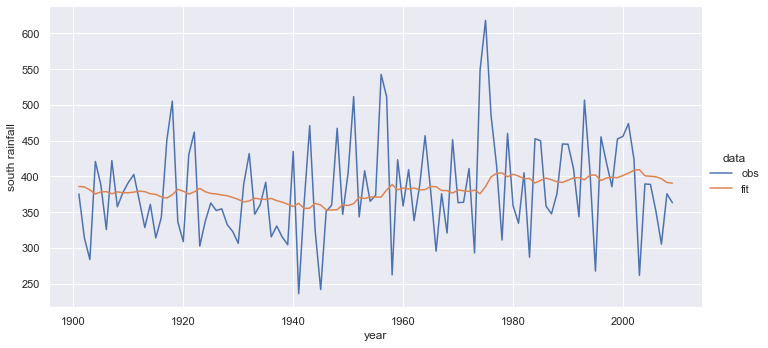

In [9]:
_gsource = time_series.melt(
    var_name='data',
    value_name='south rainfall',
    ignore_index=False
).reset_index()

sns.relplot(
        data=_gsource,
        x='year',
        y='south rainfall',
        hue='data',
        kind='line',
        aspect=2
)
plt.show()

Get the fitted model parameters.

In [10]:
pd.Series(
    data=[fitted.params['smoothing_level'], fitted.sse],
    index=['alpha', 'sse']
)

alpha         0.057959
sse      516565.109844
dtype: float64

### Check the model

Plot forecasting errors.

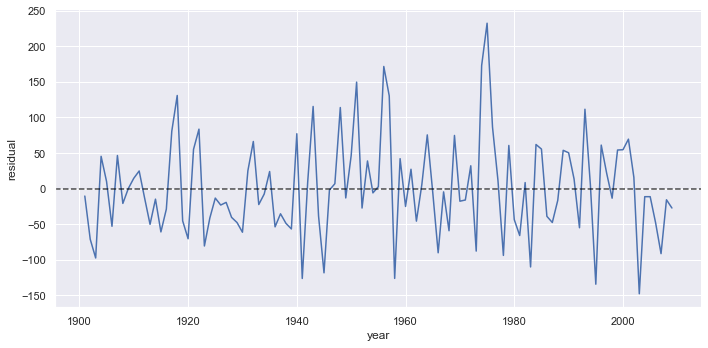

In [11]:
sns.relplot(
        x=fitted.resid.index,
        y=fitted.resid,
        kind='line',
        aspect=2
)
plt.axhline(0, alpha=0.7, ls='--', color='black')
plt.ylabel('residual')
plt.show()

Plot the in-sample autocorrelations.

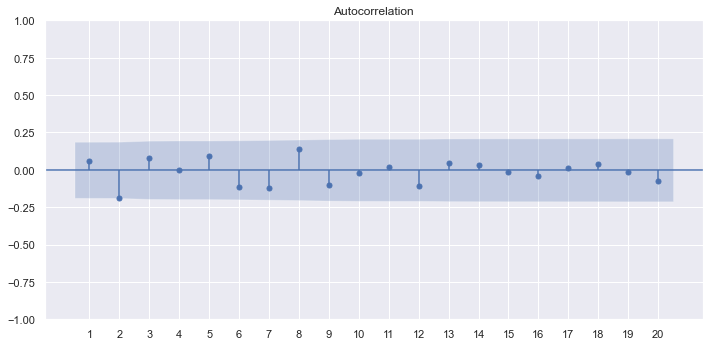

In [12]:
_f, _ax = plt.subplots(figsize=(11.8, 5.5))
tsaplots.plot_acf(fitted.resid, ax=_ax, lags=20, zero=False)
plt.xticks(range(1, 21))
plt.show()

Return the results of a Ljung-Box test.

In [13]:
sm.stats.acorr_ljungbox(fitted.resid, lags=[20])

,lb_stat,lb_pvalue
20,16.243305,0.70142


Plot a histogram of the forecasting errors.

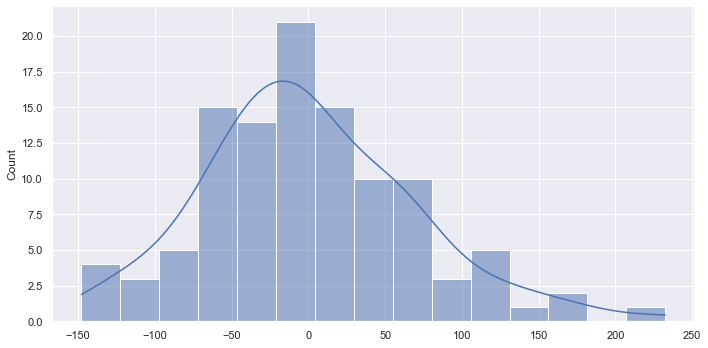

In [14]:
sns.displot(
        x=fitted.resid,
        kind='hist',
        kde=True,
        bins=15,
        aspect=2
)
plt.show()

### Forecasting

Plot forecasts for the next 3 years.

The merge is a *full outer join*[^4], given the indices of *time series* and *fcast* do not overlap.

We initialise a variable to hold reference to the forecasted values.
It is used later on to plot the vertial line, but this is vertical line is optional.
If you don't think the separator is necessary, then *_fcast* is not needed and the forecast could be moved directly into the `merge` function.

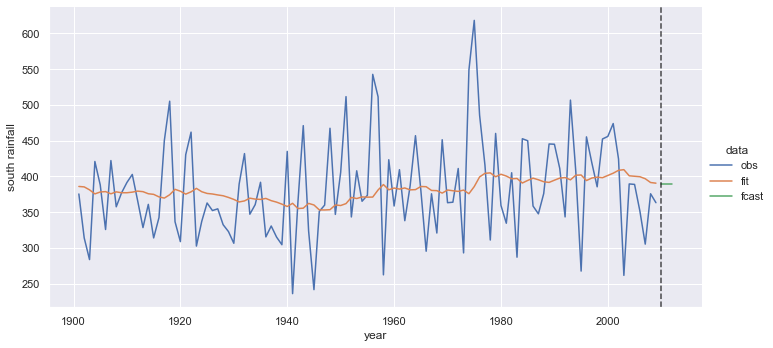

In [15]:
_fcast = fitted.forecast(3).rename('fcast')
_gsource = pd.merge(
    left=time_series,
    right=_fcast,
    how='outer',  # full outer join
    left_index=True,
    right_index=True
).rename_axis(
    'year',
    axis=0
).melt(
    var_name='data',
    value_name='south rainfall',
    ignore_index=False
).reset_index()

sns.relplot(
        data=_gsource,
        x='year',
        y='south rainfall',
        hue='data',
        kind='line',
        aspect=2
)
plt.axvline(_fcast.index[0], alpha=0.7, ls='--', color='black')
plt.show()

Quantify a forecast.

In [16]:
_fcast = fitted.forecast(1)[0]
std_err = np.sqrt(
    st.norm().ppf(0.975) * (fitted.sse / fitted.fittedvalues.size)
)
pd.Series(
    data=[_fcast, _fcast - std_err,_fcast + std_err],
    index= ['pred', 'lpb', 'upb']
)

pred    388.927004
lpb     292.550020
upb     485.303988
dtype: float64

[^1]: Arel-Bundock V (2022). Rdatasets: A collection of datasets originally distributed in various R packages. R package version 1.0.0, https://vincentarelbundock.github.io/Rdatasets
[^2]: See [The Datasets Package](https://www.statsmodels.org/devel/datasets/index.html)
[^3]: See [statsmodels.tsa.holtwinters.SimpleExpSmoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html)
[^4]: "*In theory, a **full outer join** is the combination of a left join and a right join. The full outer join includes all rows from the joined tables whether or not the other table has the matching row.*" ([sqltutorial.org](https://www.sqltutorial.org/sql-full-outer-join/))